# Segmentation

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import neptune
neptune.set_project('dalessioluca/neurons')
exp = neptune.create_experiment(name='5_neurons_exploration')    

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/neurons/e/NEUR-20


In [33]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy 
import torch
import skimage.filters
from util_luca import *

device = torch.device("cpu")
dtype = torch.float32

### Inpiut data

In [34]:
data_dir = '/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/'
file_list = next(iter(os.walk(data_dir)))[2]

print(data_dir)
print(file_list)

soma_coords_n2 = numpy.load(os.path.join(data_dir,"soma_coords_n2.npy"))
#noisy_movie_tyx = numpy.load(os.path.join(data_dir,"noisy_movie_tyx.npy"))
clean_movie_tyx = numpy.load(os.path.join(data_dir,"clean_movie_tyx.npy"))
masks_nyx = numpy.load(os.path.join(data_dir,"masks_nyx.npy"))
#background_tyx = numpy.load(os.path.join(data_dir,"background_tyx.npy"))
#clean_fluorescence_tyx = numpy.load(os.path.join(data_dir,"clean_fluorescence_tyx.npy"))
neuron_mean_fluorescence_nt = numpy.load(os.path.join(data_dir,"neuron_mean_fluorescence_nt.npy"))

/Users/ldalessi/REPOS/Optosynth/DATA/test_data_5neurons/
['noisy_movie_tyx.npy', 'clean_fluorescence_tyx.npy', 'neuron_mean_fluorescence_nt.npy', 'background_tyx.npy', 'soma_coords_n2.npy', 'clean_movie_tyx.npy', 'masks_nyx.npy']


In [35]:
clean_movie_tyx.shape

(3000, 180, 512)

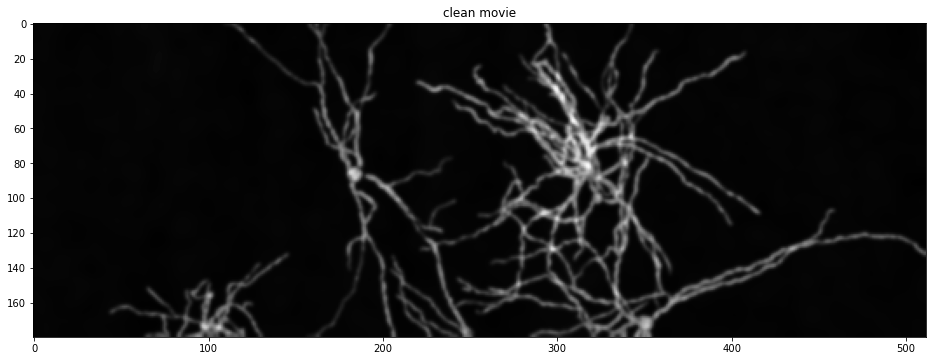

In [36]:
show_movie(clean_movie_tyx[2141:2647,::-1])

### Compute the integer mask

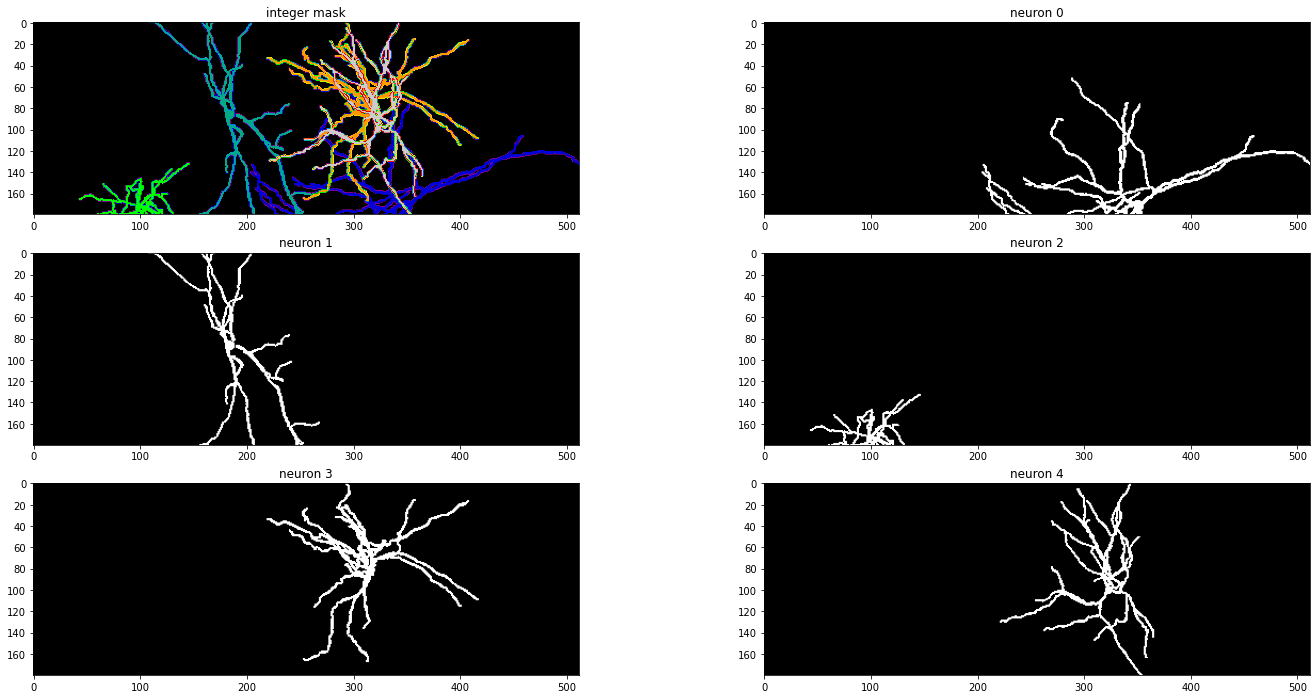

In [37]:
mask_fg = numpy.max(masks_nyx, axis=0)
integer_mask = numpy.max(masks_nyx * numpy.arange(1,masks_nyx.shape[0]+1)[...,None,None], axis=0)
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(24,12))
ax[0,0].set_title("integer mask")
ax[0,1].set_title("neuron 0")
ax[1,0].set_title("neuron 1")
ax[1,1].set_title("neuron 2")
ax[2,0].set_title("neuron 3")
ax[2,1].set_title("neuron 4")

ax[0,0].imshow(integer_mask[::-1], cmap=plt.cm.nipy_spectral)
ax[0,1].imshow(masks_nyx[0,::-1], cmap='gray')
ax[1,0].imshow(masks_nyx[1,::-1], cmap='gray')
ax[1,1].imshow(masks_nyx[2,::-1], cmap='gray')
ax[2,0].imshow(masks_nyx[3,::-1], cmap='gray')
ax[2,1].imshow(masks_nyx[4,::-1], cmap='gray')
exp.log_image("gt_masks.png", fig)


### Detrended movies

In [38]:
npzfile = numpy.load("detrended.npz")
movies = npzfile["detrended_movies"]
len(movies)

8

### Clustering with HDBSCAN

READ THIS:
https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-py

In [39]:
from sklearn.cluster import AgglomerativeClustering

detrended4 = movies[5]

w,h = detrended4.shape[-2:]
grid_x, grid_y = torch.meshgrid(torch.arange(0,w), torch.arange(0,h))
position = torch.stack((grid_x,grid_y), dim=0).numpy()
print(position.shape, detrended4.shape)

(2, 180, 512) (506, 180, 512)


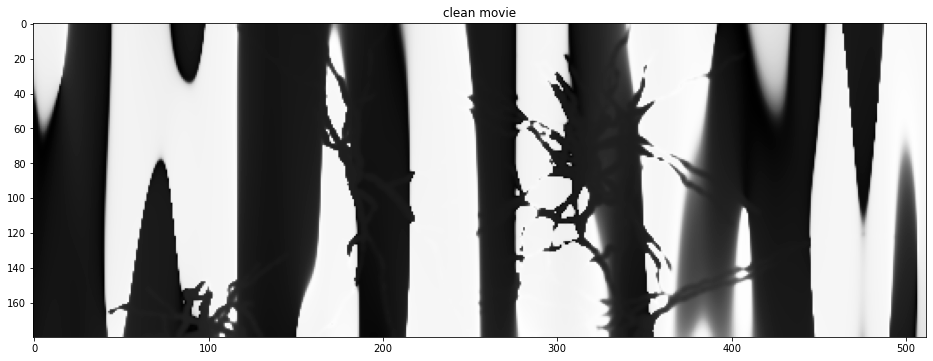

In [41]:
a = show_movie(detrended4[:,::-1])

In [52]:
numpy.save

In [49]:
numpy.savez("movie4.npy", movie=a)

In [50]:
b = numpy.load("movie4.npy")

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [42]:
type(a)

IPython.core.display.HTML

### Connected component mask

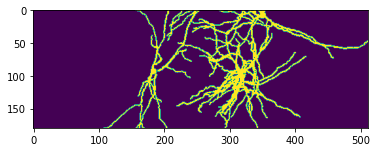

In [8]:
cc_mask = (integer_mask != 3) * (integer_mask > 0)
plt.imshow(cc_mask)

In [9]:
X = detrended4[:, cc_mask].transpose()
R = position[:, cc_mask].transpose()
print(X.shape, R.shape)

(10370, 506) (10370, 2)


### Small test

In [10]:
# USE CONNECTED COMPONENTS

In [11]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

#knn_graph = kneighbors_graph(R, n_neighbors=20, mode='connectivity',
#                             metric='minkowski', p=2, metric_params=None, 
#                             include_self=False, n_jobs=None)

knn_graph = radius_neighbors_graph(R, radius=8, mode='connectivity',
                             metric='minkowski', p=2, metric_params=None, 
                             include_self=False, n_jobs=None)

for affinity in ['euclidean', 'cosine', 'l2', 'l1']:
    for linkage in ['single', 'complete', 'ward', 'average']:
        for distance in [20, 10, 5, 2, 1.0, 0.1, 0.01]:
            model = AgglomerativeClustering(n_clusters=None, 
                                            affinity=affinity, 
                                            compute_full_tree=True,
                                            memory='./caching', 
                                            connectivity=knn_graph, 
                                            linkage=linkage, 
                                            distance_threshold=distance)
            try:
                model.fit(X)

                size_min = 100
                sizes = numpy.bincount(model.labels_)
                mask_sizes = (sizes > size_min)
                n_big_cluster = numpy.sum(mask_sizes)
                n_all_cluster = model.n_clusters_ 
                bad_to_good_labels = mask_sizes * numpy.arange(model.n_clusters_) -1 * ~mask_sizes
                
                fig, ax = plt.subplots(ncols=2, figsize=(24,6))
                fig.suptitle(str(affinity)+"_"+str(linkage)+"_"+str(distance))
                ax[0].scatter(R[:,1], R[:,0], 
                              c=bad_to_good_labels[model.labels_], 
                              cmap=plt.cm.nipy_spectral)  
                ax[0].set_title("n_cluster ALL="+str(n_all_cluster)+" BIG="+str(n_big_cluster))
                ax[1].imshow(integer_mask[::-1], cmap=plt.cm.nipy_spectral)
                plt.close(fig)
                exp.log_image("clustering_"+affinity, fig)
            except:
                print("ERROR",affinity, linkage, distance)
                pass
            

ERROR cosine ward 20
ERROR cosine ward 10
ERROR cosine ward 5
ERROR cosine ward 2
ERROR cosine ward 1.0
ERROR cosine ward 0.1
ERROR cosine ward 0.01
ERROR l2 ward 20
ERROR l2 ward 10
ERROR l2 ward 5
ERROR l2 ward 2
ERROR l2 ward 1.0
ERROR l2 ward 0.1
ERROR l2 ward 0.01
ERROR l1 ward 20
ERROR l1 ward 10
ERROR l1 ward 5
ERROR l1 ward 2
ERROR l1 ward 1.0
ERROR l1 ward 0.1
ERROR l1 ward 0.01


In [15]:
for affinity in ['cosine']:
    for linkage in ['single']:
        for distance in [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
            model = AgglomerativeClustering(n_clusters=None, 
                                            affinity=affinity, 
                                            compute_full_tree=True,
                                            memory='./caching', 
                                            connectivity=knn_graph, 
                                            linkage=linkage, 
                                            distance_threshold=distance)
            try:
                model.fit(X)

                size_min = 100
                sizes = numpy.bincount(model.labels_)
                mask_sizes = (sizes > size_min)
                n_big_cluster = numpy.sum(mask_sizes)
                n_all_cluster = model.n_clusters_ 
                bad_to_good_labels = mask_sizes * numpy.arange(model.n_clusters_) -1 * ~mask_sizes
                
                fig, ax = plt.subplots(ncols=2, figsize=(24,6))
                fig.suptitle(str(affinity)+"_"+str(linkage)+"_"+str(distance))
                ax[0].scatter(R[:,1], R[:,0], 
                              c=bad_to_good_labels[model.labels_], 
                              cmap=plt.cm.nipy_spectral)  
                ax[0].set_title("n_cluster ALL="+str(n_all_cluster)+" BIG="+str(n_big_cluster))
                ax[1].imshow(integer_mask[::-1], cmap=plt.cm.nipy_spectral)
                plt.close(fig)
                exp.log_image("clustering_refinement_"+affinity, fig)
            except:
                print("ERROR",affinity, linkage, distance)
                pass

In [ ]:
for affinity in ['cosine']:
    for linkage in ['average']:
        for distance in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
            model = AgglomerativeClustering(n_clusters=None, 
                                            affinity=affinity, 
                                            compute_full_tree=True,
                                            memory='./caching', 
                                            connectivity=knn_graph, 
                                            linkage=linkage, 
                                            distance_threshold=distance)
            try:
                model.fit(X)

                size_min = 100
                sizes = numpy.bincount(model.labels_)
                mask_sizes = (sizes > size_min)
                n_big_cluster = numpy.sum(mask_sizes)
                n_all_cluster = model.n_clusters_ 
                bad_to_good_labels = mask_sizes * numpy.arange(model.n_clusters_) -1 * ~mask_sizes
                
                fig, ax = plt.subplots(ncols=2, figsize=(24,6))
                fig.suptitle(str(affinity)+"_"+str(linkage)+"_"+str(distance))
                ax[0].scatter(R[:,1], R[:,0], 
                              c=bad_to_good_labels[model.labels_], 
                              cmap=plt.cm.nipy_spectral)  
                ax[0].set_title("n_cluster ALL="+str(n_all_cluster)+" BIG="+str(n_big_cluster))
                ax[1].imshow(integer_mask[::-1], cmap=plt.cm.nipy_spectral)
                plt.close(fig)
                exp.log_image("clustering_refinement_"+affinity, fig)
            except:
                print("ERROR",affinity, linkage, distance)
                pass

In [14]:
for affinity in ['cosine']:
    for linkage in ['complete']:
        for distance in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
            model = AgglomerativeClustering(n_clusters=None, 
                                            affinity=affinity, 
                                            compute_full_tree=True,
                                            memory='./caching', 
                                            connectivity=knn_graph, 
                                            linkage=linkage, 
                                            distance_threshold=distance)
            try:
                model.fit(X)

                size_min = 100
                sizes = numpy.bincount(model.labels_)
                mask_sizes = (sizes > size_min)
                n_big_cluster = numpy.sum(mask_sizes)
                n_all_cluster = model.n_clusters_ 
                bad_to_good_labels = mask_sizes * numpy.arange(model.n_clusters_) -1 * ~mask_sizes
                
                fig, ax = plt.subplots(ncols=2, figsize=(24,6))
                fig.suptitle(str(affinity)+"_"+str(linkage)+"_"+str(distance))
                ax[0].scatter(R[:,1], R[:,0], 
                              c=bad_to_good_labels[model.labels_], 
                              cmap=plt.cm.nipy_spectral)  
                ax[0].set_title("n_cluster ALL="+str(n_all_cluster)+" BIG="+str(n_big_cluster))
                ax[1].imshow(integer_mask[::-1], cmap=plt.cm.nipy_spectral)
                plt.close(fig)
                exp.log_image("clustering_refinement_"+affinity, fig)
            except:
                print("ERROR",affinity, linkage, distance)
                pass

# Preferential attachment. Each pixel is connected to the top 5.

In [ ]:
    https://www.youtube.com/watch?v=dGsxd67IFiU

In [ ]:
READ THIS AGAIN:
    https://www.youtube.com/watch?v=dGsxd67IFiU

## Can I extract the foreground?

## Revisit this question later

In [ ]:
plt.imshow(numpy.max(mu_tyx, axis=0))

# Create graph using z_unnormalized

In [ ]:
import torch
import torch.nn.functional as F
from typing import NamedTuple, Optional


class SparseSimilarity(NamedTuple):
    sparse_matrix: torch.sparse.FloatTensor
    index_matrix: torch.tensor
        

def roller_2d(a: torch.tensor, b: Optional[torch.tensor] = None, radius: float = 2):
    """ Performs rolling of the last two spatial dimensions.
        For each point consider half a square. Each pair of points will appear once.
        Number of channels: [(2r+1)**2 - 1]/2
        For example for a radius = 2 the full square is 5x5. The number of pairs is: 12
    """
    max_distance = int(radius) + 1
    radius2 = radius*radius
    dxdy_list = []
    for dx in range(0, max_distance + 1):
        for dy in range(-max_distance, max_distance + 1):
            d2 = dx*dx + dy*dy
            half = dx>0 or (dx == 0 and dy>0)
            if d2<= radius2 and half:
                dxdy_list.append((dx, dy))
                # print(dx,dy)

    for dxdy in dxdy_list:
        # print("--->",dxdy)
        a_tmp = torch.roll(torch.roll(a, dxdy[0], dims=-2), dxdy[1], dims=-1)
        b_tmp = None if b is None else torch.roll(torch.roll(b, dxdy[0], dims=-2), dxdy[1], dims=-1)
        yield a_tmp, b_tmp
        
        
def compute_sparse_similarity_matrix(movie_tyx: torch.tensor,
                                     radius_nn: int,
                                     min_threshold: float = 0.2,
                                     fg_mask: Optional[torch.tensor]=None,) -> torch.sparse.FloatTensor:
    """ Compute the similarity between two pixels by computing the product of the pixel traces.
        If the similarity is less than min_threshold the value is not recorded (i.e. effectively zero)
        to save memory.

        INPUT: movie_tyx shape --> t_frames, w, h
        OUTPUT: sparse tensor fo size (max_index, max_index)
    """
    with torch.no_grad():
        
        t,w,h = movie_tyx.shape
        if fg_mask is None:
            index_yx = torch.arange(w*h, device=movie_tyx.device, dtype=torch.long)
            max_index = w*h-1
        else:
            print(fg_mask.dtype)
            assert fg_mask.dtype == torch.bool
            index_yx = -1 * torch.ones(fg_mask.shape, device=movie_tyx.device, dtype=torch.long)
            max_index = torch.sum(fg_mask).item()
            index_yx[fg_mask] = torch.arange(max_index, device=movie_tyx.device, dtype=torch.long)
        print("max_index", max_index)
        
        # Pad width and height with zero before rolling to avoid spurious connections due to PBC
        pad = radius_nn + 1
        pad_movie_tyx = F.pad(movie_tyx, pad=[pad, pad, pad, pad], mode="constant", value=0.0)
        pad_index = F.pad(index_yx, pad=[pad, pad, pad, pad], mode="constant", value=-1)
        row = index_yx # shape: w, h
        row_ge_0 = (row >= 0)

        sparse_similarity = torch.sparse.FloatTensor(max_index, max_index).to(movie_tyx.device)
        for pad_movie_tyx_shifted, pad_index_shifted in roller_2d(a=pad_movie_tyx,
                                                                  b=pad_index,
                                                                  radius=radius_nn):
            v = (pad_movie_tyx_shifted * pad_movie_tyx).sum(dim=-3)[pad:(pad + w), pad:(pad + h)].pow(2)  # shape: w, h
            col = pad_index_shifted[pad:(pad + w), pad:(pad + h)]  # shape: batch, w, h
            mask = (v > min_threshold) * (col >= 0) * row_ge_0
            index_tensor = torch.stack((row[mask], col[mask]), dim=0)
            tmp_similarity = torch.sparse.FloatTensor(index_tensor, v[mask],
                                                      torch.Size([max_index, max_index]))
            sparse_similarity.add_(tmp_similarity)
            sparse_similarity = sparse_similarity.coalesce()

        return SparseSimilarity(sparse_matrix=sparse_similarity,
                                index_matrix=index_yx)
    
print(fg_mask.shape)

### Here I am cheating a bit and assuming that I know the foreground

In [ ]:
fg_mask_torch = torch.from_numpy(fg_mask)
plt.imshow(fg_mask_torch)  

In [ ]:
similarity = compute_sparse_similarity_matrix(movie_tyx=torch.from_numpy(z).float().cuda(),
                                              fg_mask=fg_mask_torch,
                                              radius_nn=20,
                                              min_threshold=0.95)

plt.imshow(similarity.index_matrix.cpu().numpy())

In [ ]:

class Suggestion(NamedTuple):
    best_resolution: float
    best_index: int
    sweep_resolution: torch.Tensor
    sweep_mi: torch.Tensor
    sweep_iou: torch.Tensor
    sweep_delta_n: torch.Tensor
    sweep_seg_mask: torch.Tensor
    sweep_n_cells: torch.Tensor
    sweep_sizes: list
        
    def show_index(self, index: int, figsize: tuple = (12, 12), fontsize: int = 20):
        figure, ax = plt.subplots(figsize=figsize)
        ax.imshow(skimage.color.label2rgb(label=self.sweep_seg_mask[index].cpu().numpy(), bg_label=0))
        ax.set_title('resolution = {0:.3f}, \
                      iou = {1:.3f}, \
                      delta_n = {2:3d}, \
                      n_cells = {3:3d}'.format(self.sweep_resolution[index],
                                               self.sweep_iou[index],
                                               self.sweep_delta_n[index],
                                               self.sweep_n_cells[index]),
                     fontsize=fontsize)
        
    def show_best(self, figsize: tuple = (12, 12), fontsize: int = 20):
        return self.show_index(self.best_index, figsize, fontsize)
        
    def show_graph(self, figsize: tuple = (12, 12), fontsize: int = 20):
        figure, ax = plt.subplots(figsize=figsize)
        ax.set_title('Resolution sweep', fontsize=fontsize)
        ax.set_xlabel("resolution", fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        
        color = 'tab:red'
        _ = ax.plot(self.sweep_resolution, self.sweep_n_cells, '.--', label="n_cell", color=color)
        ax.set_ylabel('n_cell', color=color, fontsize=fontsize)
        ax.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
        ax.legend(loc='upper left', fontsize=fontsize)
        ax.grid()

        ax_2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:green'
        _ = ax_2.plot(self.sweep_resolution, self.sweep_iou, '-', label="iou", color=color)
        ax_2.set_ylabel('Intersection Over Union', color=color, fontsize=fontsize)
        ax_2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
        ax_2.legend(loc='upper right', fontsize=fontsize)

        
class Partition(NamedTuple):
    sizes: torch.tensor  # both for bg and fg. It is simply obtained by numpy.bincount(membership)
    membership: torch.tensor  # bg=0, fg=1,2,3,.....

    def compactify(self):
        """ if there are gaps in the SIZES, then shift both membership and sizes accordingly"""
        if (self.sizes[1:] > 0).all():
            return self
        else:
            my_filter = self.sizes > 0
            my_filter[0] = True
            count = torch.cumsum(my_filter, dim=-1)
            old_2_new = ((count - count[0]) * my_filter).to(self.membership.dtype)
            return Partition(sizes=self.sizes[my_filter], membership=old_2_new[self.membership])

    def filter_by_vertex(self, keep_vertex: torch.tensor):
        assert self.membership.shape == keep_vertex.shape
        assert keep_vertex.dtype == torch.bool
            
        if keep_vertex.all():
            return self
        else:
            new_membership = self.membership * keep_vertex  # put all bad vertices in the background cluster
            return Partition(sizes=torch.bincount(new_membership),
                             membership=new_membership).compactify()

    def filter_by_size(self,
                       min_size: Optional[int] = None,
                       max_size: Optional[int] = None):
        """ If a cluster is too small or too large, its label is set to zero (i.e. background value).
            The other labels are adjusted so that there are no gaps in the labels number.
            Min_size and Max_size are integers specifying the number of pixels.
        """
        if (min_size is None) and (max_size is None):
            return self
        elif (min_size is not None) and (max_size is not None):
            assert max_size > min_size > 0, "Condition max_size > min_size > 0 failed."
            my_filter = (self.sizes > min_size) * (self.sizes < max_size)
        elif min_size is not None:
            assert min_size > 0, "Condition min_size > 0 failed."
            my_filter = (self.sizes > min_size)
        elif max_size is not None:
            assert max_size > 0, "Condition max_size > 0 failed."
            my_filter = (self.sizes < max_size)
        else:
            raise Exception("you should never be here!!")

        my_filter[0] = True  # always keep the bg
        if my_filter.all():
            return self
        else:
            return Partition(sizes=self.sizes * my_filter,
                             membership=self.membership).compactify()

In [ ]:

import torch
import numpy
import skimage.segmentation
import skimage.color
import leidenalg as la
import igraph as ig
from typing import Optional, List, Iterable
from matplotlib import pyplot as plt

with torch.no_grad():
    
    class GraphSegmentation(object):
        """ Produce a consensus segmentation mask by finding communities on a graph.
            Each node is a foreground pixel and each edge is the similarity between spatially nearby pixels.
            The similarity measures if the pixels belong to the same object.

            Typical usage:
            g = GraphSegmentation(tiling)

            disconnected_components = g.graph.clusters(mode="STRONG")
            community1=g.partition_2_community(disconnected_components)
            g.plot_community(community1, figsize=(20,20))


            partition = g.find_partition(resolution = 0.03)
            community2 = g.partition_2_community(partition, size_threshold=10)
            g.plot_community(community2, figsize=(20,20))
        """

        def __init__(self, similarity: SparseSimilarity,
                     min_edge_weight: Optional[float] = 0.1,
                     normalize_graph_edges: bool = False) -> None:
            super().__init__()

            if torch.cuda.is_available():
                self.device = torch.device("cuda:0")
            else:
                self.device = torch.device("cpu")
                
            # it should be able to handle both DenseSimilarity and SparseSimilarity
            self.index_matrix = None
            self.n_fg_pixel = None
            self.i_coordinate_fg_pixel = None
            self.j_coordinate_fg_pixel = None
            self.graph = self.similarity_2_graph(similarity=similarity,
                                                 min_edge_weight=min_edge_weight,
                                                 normalize_graph_edges=normalize_graph_edges)

        def similarity_2_graph(self, similarity: SparseSimilarity,
                               min_edge_weight: float,
                               normalize_graph_edges: bool) -> ig.Graph:
            """ Create the graph from the sparse similarity matrix """
            if not normalize_graph_edges:
                print("WARNING! You are going to create a graph without normalizing the edges by the sqrt of the node degree. \
                       Are you sure you know what you are doing?!")

            # Move operation on GPU is available. Only at the end move back to cpu
            if torch.cuda.is_available():
                sparse_matrix = similarity.sparse_matrix.cuda()
                self.index_matrix = similarity.index_matrix.cuda()
            else:
                sparse_matrix = similarity.sparse_matrix.cpu()
                self.index_matrix = similarity.index_matrix.cpu()
                
            assert sparse_matrix._nnz() > 0, "WARNING: Graph is empty. Nothing to do"
            
            self.n_fg_pixel = torch.sum(self.index_matrix>=0)
            ni, nj = self.index_matrix.shape[-2:]
            i_matrix, j_matrix = torch.meshgrid([torch.arange(ni, dtype=torch.long, device=self.index_matrix.device),
                                                 torch.arange(nj, dtype=torch.long, device=self.index_matrix.device)])
            self.i_coordinate_fg_pixel = i_matrix[self.index_matrix >= 0]
            self.j_coordinate_fg_pixel = j_matrix[self.index_matrix >= 0]

            # Do the filtering
            v_tmp = sparse_matrix._values()
            ij_tmp = sparse_matrix._indices()
            my_filter = (v_tmp > min_edge_weight) * (ij_tmp[0, :] >= 0) * (ij_tmp[1, :] >= 0)
            v = v_tmp[my_filter]
            ij = ij_tmp[:, my_filter]
            
            # Normalize the edges if necessary
            if normalize_graph_edges:
                # Before normalization v ~ 1.
                # After normalization v ~ 1/#neighbors so that sum_i v_ij ~ 1
                m = torch.sparse.FloatTensor(ij, v, torch.Size([self.n_fg_pixel, self.n_fg_pixel]))
                if m._nnz() > 0:
                    m_tmp = (torch.sparse.sum(m, dim=-1) + torch.sparse.sum(m, dim=-2)).coalesce()
                    sqrt_sum_edges_at_vertex = torch.sqrt(m_tmp._values())
                    v.div_(sqrt_sum_edges_at_vertex[ij[0]]*sqrt_sum_edges_at_vertex[ij[1]])
                else:
                    raise Exception("WARNING: Graph is empty. Nothing to do")

            print("Building the graph with python-igraph")
            return ig.Graph(vertex_attrs={"label": numpy.arange(self.n_fg_pixel, dtype=numpy.int64)},
                            edges=ij.permute(1, 0).cpu().numpy(),
                            edge_attrs={"weight": v.cpu().numpy()},
                            graph_attrs={"total_edge_weight": v.sum().item(),
                                         "total_nodes": self.n_fg_pixel},
                            directed=False)

        def partition_2_integer_mask(self, partition: Partition):
            label = torch.zeros_like(self.index_matrix, 
                                     dtype=partition.membership.dtype,
                                     device=partition.membership.device)
            label[self.i_coordinate_fg_pixel, self.j_coordinate_fg_pixel] = partition.membership
            return label

        def is_vertex_in_window(self, window: tuple):
            """ Same convention as scikit image:
                window = (min_row, min_col, max_row, max_col)
                Return boolean array describing whether the vertex is in the spatial windows
            """
            row_filter = (self.i_coordinate_fg_pixel >= window[0]) * (self.i_coordinate_fg_pixel < window[2])
            col_filter = (self.j_coordinate_fg_pixel >= window[1]) * (self.j_coordinate_fg_pixel < window[3])
            vertex_in_window = row_filter * col_filter
            if (~vertex_in_window).all():
                raise Exception("All vertices are outside the chosen window. \
                                 This is wrong. Doulbe check your window specifications")
            return vertex_in_window

        def subgraphs_by_partition_and_window(self,
                                              partition: Optional[Partition],
                                              window: Optional[tuple],
                                              include_bg: bool = False) -> List[ig.Graph]:
            """ same covention as scikit image: window = (min_row, min_col, max_row, max_col) """

            if (partition is None) and (window is None):
                # nothing to do
                for i in range(1):
                    yield self.graph

            elif (partition is None) and (window is not None):
                # return a single graph by window
                mask_vertex_in_window = self.is_vertex_in_window(window)  # torch.bool
                vertex_label = torch.tensor(self.graph.vs["label"], dtype=torch.long, device=self.device)
                for i in range(1):
                    yield self.graph.subgraph(vertices=vertex_label[mask_vertex_in_window])

            elif partition is not None:
                # return many graphs

                if window is None:
                    vertex_in_window = torch.ones_like(partition.membership).bool()
                else:
                    vertex_in_window = self.is_vertex_in_window(window)

                vertex_label = torch.tensor(self.graph.vs["label"], dtype=torch.long, device=self.device)
                n_start = 0 if include_bg else 1
                for n in range(n_start, len(partition.sizes)):
                    vertex_mask = (partition.membership == n) * vertex_in_window
                    yield self.graph.subgraph(vertices=vertex_label[vertex_mask])

        def suggest_resolution_parameter(self,
                                         window: Optional[tuple] = None,
                                         min_size: Optional[float] = 20,
                                         max_size: Optional[float] = None,
                                         cpm_or_modularity: str = "cpm",
                                         each_cc_separately: bool = False,
                                         sweep_range: Optional[Iterable] = None) -> Suggestion:
            """ This function select the resolution parameter which gives the hightest
                Intersection Over Union with the target partition.
                By default the target partition is self.partition_sample_segmask.

                To speed up the calculation the optimal resolution parameter is computed based
                on a windows of the original image. If window is None the entire image is used. This might be very slow.
                
                Only CPM is scale invariant. 
                If using modularity the same resolution paerameter will give different results depending on the size of the analyzed window.

                The suggested resolution parameter is NOT necessarily optimal.
                Try smaller values to undersegment and larger value to oversegment.

                window = (min_row, min_col, max_row, max_col)
            """
            # filter by window
            if window is None:
                window = [0, 0, self.raw_image.shape[-2], self.raw_image.shape[-1]]
            else:
                window = (max(0, window[0]),
                          max(0, window[1]),
                          min(self.raw_image.shape[-2], window[2]),
                          min(self.raw_image.shape[-1], window[3]))

            other_integer_mask = remove_label_gaps(self.example_integer_mask[window[0]:window[2], window[1]:window[3]]).long()            

            resolutions = torch.arange(0.5, 10, 0.5) if sweep_range is None else sweep_range
            iou = torch.zeros(len(resolutions), dtype=torch.float)
            mi = torch.zeros_like(iou)
            n_reversible_instances = torch.zeros_like(iou)
            total_intersection = torch.zeros_like(iou)
            integer_mask = torch.zeros((resolutions.shape[0], window[2]-window[0],
                                        window[3]-window[1]), dtype=torch.int)
            delta_n_cells = torch.zeros(resolutions.shape[0], dtype=torch.int)
            n_cells = torch.zeros_like(delta_n_cells)
            sizes_list = list()
            
            for n, res in enumerate(resolutions):
                if (n % 10 == 0) or (n == len(resolutions)-1):
                    print("resolution sweep, {0:3d} out of {1:3d}".format(n, resolutions.shape[0]-1))
                
                p_tmp = self.find_partition_leiden(resolution=res,
                                                   window=window,
                                                   min_size=min_size,
                                                   max_size=max_size,
                                                   cpm_or_modularity=cpm_or_modularity,
                                                   each_cc_separately=each_cc_separately)
                int_mask = self.partition_2_integer_mask(p_tmp)[window[0]:window[2], window[1]:window[3]]
                sizes_list.append(p_tmp.sizes.cpu())

                n_cells[n] = len(p_tmp.sizes)-1
                integer_mask[n] = int_mask.cpu()
                c_tmp: ConcordanceIntMask = concordance_integer_masks(integer_mask[n].to(other_integer_mask.device, 
                                                                                         other_integer_mask.dtype), other_integer_mask)
                delta_n_cells[n] = c_tmp.delta_n
                iou[n] = c_tmp.iou
                mi[n] = c_tmp.mutual_information
                n_reversible_instances[n] = c_tmp.n_reversible_instances
                total_intersection[n] = c_tmp.intersection_mask.sum().float()

            i_max = torch.argmax(iou).item()
            try:
                best_resolution = resolutions[i_max].item()
            except:
                best_resolution = resolutions[i_max]

            return Suggestion(best_resolution=best_resolution,
                              best_index=i_max,
                              sweep_resolution=resolutions,
                              sweep_mi=mi,
                              sweep_iou=iou,
                              sweep_delta_n=delta_n_cells,
                              sweep_seg_mask=integer_mask,
                              sweep_sizes=sizes_list,
                              sweep_n_cells=n_cells)

        # TODO use built-in leiden algorithm instead of leidenalg?
        def find_partition_leiden(self,
                                  resolution: float,
                                  window: Optional[tuple] = None,
                                  min_size: Optional[float] = 20,
                                  max_size: Optional[float] = None,
                                  cpm_or_modularity: str = "cpm",
                                  each_cc_separately: bool = False,
                                  n_iterations: int = 2,
                                  initial_membership: Optional[numpy.ndarray] = None) -> Partition:
            """ Find a partition of the graph by greedy maximization of CPM or Modularity metric.
                The graph can have both normalized and un-normalized weight.
                The strong recommendation is to use CPM with normalized edge weight.
                
                The metric can be both cpm or modularity
                The results are all similar (provided the resolution parameter is tuned correctly).

                If you want to use the suggest_resolution_parameter function with full automatic you should use either:
                1. CPM with normalized edge weight
                2. MODULARITY with UN Normalized edge_weight

                You can also pass a sweep_range.

                The resolution parameter can be increased (to obtain smaller communities) or
                decreased (to obtain larger communities).

                To speed up the calculation the graph partitioning can be done separately for each connected components.
                This is absolutely ok for CPM metric while a bit questionable for Modularity metric.
                It is not likely to make much difference either way.

                window has the same convention as scikit image, i.e. window = (min_row, min_col, max_row, max_col)
            """
            
            if cpm_or_modularity == "cpm":
                partition_type = la.CPMVertexPartition
                
                # Rescale the resolution by some (robust) properties of the full graph
                # so that the right resolution parameter is about 1
                n = self.graph["total_nodes"]
                overall_graph_density = self.graph["total_edge_weight"] * 2.0 / (n * (n - 1))
                resolution = overall_graph_density * resolution
                
            elif cpm_or_modularity == "modularity":
                partition_type = la.RBConfigurationVertexPartition
            else:
                raise Exception("Warning!! Argument not recognized. \
                                           CPM_or_modularity can only be 'CPM' or 'modularity'")

            # Subset graph by connected components and windows if necessary
            max_label = 0
            membership = torch.zeros(self.n_fg_pixel, dtype=torch.long, device=self.device)
            partition_for_subgraphs = self.get_cc_partition() if each_cc_separately else None

            for n, g in enumerate(self.subgraphs_by_partition_and_window(window=window,
                                                                         partition=partition_for_subgraphs)):
                
                # With this rescaling the value of the resolution parameter optimized 
                # for a small window can be used to segment a large window
                if cpm_or_modularity == "modularity":
                    tmp = numpy.sum(g.es["weight"]) / g["total_edge_weight"]
                    resolution = resolution * tmp

                if g.vcount() > 0:
                    # Only if the graph has node I tried to find the partition

                    print("find partition internal")
                    p = la.find_partition(graph=g,
                                          partition_type=partition_type,
                                          initial_membership=initial_membership,
                                          weights=g.es['weight'],
                                          n_iterations=n_iterations,
                                          resolution_parameter=resolution)

                    labels = torch.tensor(p.membership, device=self.device, dtype=torch.long) + 1
                    shifted_labels = labels + max_label
                    max_label += torch.max(labels)
                    membership[g.vs['label']] = shifted_labels
                    
            # TODO: filter_by_size is slow
            return Partition(sizes=torch.bincount(membership),
                             membership=membership).filter_by_size(min_size=min_size, max_size=max_size)

        def plot_partition(self, partition: Partition,
                           figsize: Optional[tuple] = (12, 12),
                           window: Optional[tuple] = None,
                           **kargs) -> torch.tensor:
            """
                If partition is None it prints the connected components
                window has the same convention as scikit image, i.e. window = (min_row, min_col, max_row, max_col)
                kargs can include:
                density=True, bins=50, range=(10,100), ...
            """

            if window is None:
                w = [0, 0, self.raw_image.shape[-2], self.raw_image.shape[-1]]
                sizes_fg = partition.sizes[1:]  # no background
            else:
                sizes = torch.bincount(self.is_vertex_in_window(window=window) * partition.membership)
                sizes_fg = sizes[1:]  # no background
                sizes_fg = sizes_fg[sizes_fg > 0]  # since I am filtering the vertex some sizes might become zero
                w = window

            integer_mask = self.partition_2_integer_mask(partition)[w[0]:w[2], w[1]:w[3]].cpu().long().numpy()  # shape: w, h
            image = self.raw_image[:, w[0]:w[2], w[1]:w[3]].permute(1, 2, 0).cpu().float().numpy()  # shape: w, h, ch
            if len(image.shape) == 3 and (image.shape[-1] != 3):
                image = image[..., 0]

            fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize)
            axes[0, 0].imshow(skimage.color.label2rgb(label=integer_mask,
                                                      bg_label=0))
            axes[0, 1].imshow(skimage.color.label2rgb(label=integer_mask,
                                                      image=image,
                                                      alpha=0.25,
                                                      bg_label=0))
            axes[1, 0].imshow(image)
            axes[1, 1].hist(sizes_fg.cpu(), **kargs)
            
            title_partition = 'Partition, #cells -> '+str(sizes_fg.shape[0])
            axes[0, 0].set_title(title_partition)
            axes[0, 1].set_title(title_partition)
            axes[1, 0].set_title("raw image")
            axes[1, 1].set_title("size distribution")

In [ ]:
g = GraphSegmentation(similarity,
                      min_edge_weight = 0.01,
                      normalize_graph_edges = False)

In [ ]:
print(g.index_matrix.shape)
plt.imshow(g.index_matrix.cpu())

In [ ]:
g.graph.summary()

In [ ]:
window = [0,100,200, 300]
partition = g.find_partition_leiden(resolution=0.1,
                                    window=window,
                                    min_size= 100,
                                    max_size= None,
                                    cpm_or_modularity = "modularity",
                                    each_cc_separately = False,
                                    n_iterations = 2,
                                    initial_membership = None)

In [ ]:
print(partition)

In [ ]:
partition.sizes.shape

In [ ]:
labels = g.partition_2_integer_mask(partition).cpu().numpy()
print(labels.shape)
print(numpy.max(labels))

fig, ax = plt.subplots(nrows=5,figsize=(12,12))
ax[0].imshow(skimage.color.label2rgb(label=labels, bg_label=0))
ax[1].imshow(skimage.color.label2rgb(label=integer_mask, bg_label=0))
ax[2].imshow(masks_nyx[12])
ax[3].imshow(labels==2)
ax[4].imshow(labels==11)

In [ ]:
N = partition.sizes.shape[0]
ncols=4
nrows=1+N//ncols
print(ncols, nrows)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,6*nrows))
for n in range(0, N):
    r = n//ncols
    c = n%ncols
    ax[r,c].imshow(labels==n)

In [ ]:
N = masks_nyx.shape[0]
ncols=4
nrows=1+N//ncols
print(ncols, nrows)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,6*nrows))
for n in range(0, N):
    r = n//ncols
    c = n%ncols
    ax[r,c].imshow(masks_nyx[n])

In [ ]:
partition.compactify()

In [ ]:
labels==11

### labels = g.partition_2_integer_mask(partition).cpu().numpy()
print(labels.shape)
print(numpy.max(labels))

fig, ax = plt.subplots(nrows=5,figsize=(12,12))
ax[0].imshow(skimage.color.label2rgb(label=labels, bg_label=0))
ax[1].imshow(skimage.color.label2rgb(label=integer_mask, bg_label=0))
ax[2].imshow(masks_nyx[12])
ax[3].imshow(labels==2)
ax[4].imshow(labels==2)

In [ ]:
plt.imshow(masks_nyx[12])

In [ ]:
print(numpy.min(dot_product_wrt_ref))
print(numpy.max(dot_product_wrt_ref))
a = numpy.unravel_index(numpy.argmax(dot_product_wrt_ref.reshape(-1)),dot_product_wrt_ref.shape)
print(a)
print(soma_coords_n2[n])

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(12,12))
ax[0].imshow(dot_product_wrt_ref)
ax[1].imshow(masks_nyx[n])
#ax.scatter(soma_coords_n2[n,0],soma_coords_n2[n,1], color='red', s=20)
#ax.scatter(a[1],a[0], color='black', s=20)

### mu_tyx, std_tyx = mu_std_moving_average(clean_movie_tyx, axis=0, window_type='center', window_size=300)


numpy.mean(, axis=(-1,-2))
movie_std_t = numpy.std(clean_movie_tyx, axis=(-1,-2))
detrended_tyx = (clean_movie_tyx - movie_mu_t.reshape(-1,1,1))/ movie_std_t.reshape(-1,1,1)

In [ ]:
detrended_mu_t = numpy.mean(detrended_tyx, axis=(-1,-2))
detrended_std_t = numpy.std(detrended_tyx, axis=(-1,-2))

fontsize=20
a, b = 0, 500
fig, ax = plt.subplots(nrows=2, figsize=(12,12))
ax[0].plot(movie_trace)
ax[1].plot(detrended_mu_t)
ax[1].plot(detrended_std_t)

### Compute the dot troduct of traces

In [ ]:
numpy.where

### For each frame compute mean and std across pixels and normalize the frame

In [ ]:
movie_mu_t = numpy.mean(clean_movie_tyx, axis=(-1,-2))
movie_std_t = numpy.std(clean_movie_tyx, axis=(-1,-2))
detrended_tyx = (clean_movie_tyx - movie_mu_t.reshape(-1,1,1))/ movie_std_t.reshape(-1,1,1)

In [ ]:
detrended_mu_t = numpy.mean(detrended_tyx, axis=(-1,-2))
detrended_std_t = numpy.std(detrended_tyx, axis=(-1,-2))

fontsize=20
a, b = 0, 500
fig, ax = plt.subplots(nrows=2, figsize=(12,12))
ax[0].plot(movie_trace)
ax[1].plot(detrended_mu_t)
ax[1].plot(detrended_std_t)

### Compute the dot troduct of traces

In [ ]:
print(soma_coords_n2.shape)
shift_x, shift_y = 10, 10
n=0
for shift in [0,1,5,10,20,30]:
    plt.plot(detrended_tyx[:,soma_coords_n2[n,1]+shift,soma_coords_n2[n,0]+shift], label="shift "+str(shift))
plt.legend()

In [ ]:
ref = detrended_tyx[:,soma_coords_n2[n,1],soma_coords_n2[n,0]].reshape(-1,1,1)
dot_product_wrt_ref = numpy.sum(detrended_tyx * ref, axis=0)

fig, ax = plt.subplots(nrows=2, figsize=(12,12))
ax[0].imshow(dot_product_wrt_ref)

### Option 1: For each interval compute pixel mean and std

In [ ]:
detrended = numpy.zeros_like(clean_movie_tyx)

for n in range(N_interval):
    i_left = bp[n]+avoid_region_near_bp
    i_right = bp[n+1]-avoid_region_near_bp
    
    mu_yx = numpy.mean(clean_movie_tyx[i_left:i_right], axis=0)
    std_yx = numpy.std(clean_movie_tyx[i_left:i_right], axis=0)
    
    detrended[i_left:i_right] = (clean_movie_tyx[i_left:i_right]-mu_yx)/std_yx

In [ ]:
trace_detrended_mu = numpy.mean(detrended,axis=(-1,-2))
trace_detrended_std = numpy.std(detrended,axis=(-1,-2))

### Option 2: For each frame compute mean and std and normalize that frame 

In [ ]:
trace_detrended_mu_3 = numpy.mean(detrended_3,axis=(-1,-2))
trace_detrended_std_3 = numpy.std(detrended_3,axis=(-1,-2))

In [ ]:
fontsize=20
a, b = 0, 500
fig, ax = plt.subplots(nrows=3, figsize=(12,12))
ax[0].plot(movie_trace)
ax[1].plot(trace_detrended_mu_3)
ax[1].plot(trace_detrended_std_3)
ax[2].plot(trace_detrended_mu_3[a:b])
ax[2].plot(trace_detrended_std_3[a:b])


In [ ]:
plt.plot(detrended[:,120,120])
plt.plot(detrended[:,120,140])

In [ ]:
plt.imshow(detrended[139])

In [ ]:
plt.imshow(detrended[340])

In [ ]:
plt.imshow(detrended[240])

In [ ]:

def get_flanking_segments(
        movie_txy: np.ndarray,
        i_stim: int,
        trim_config: dict) -> Tuple[np.ndarray, np.ndarray]:
    t_begin_left = (
        trim_config['n_frames_total'] * i_stim
        + trim_config['trim_left'])
    t_end_left = t_begin_left + trim_config['n_frames_fit_left']
    
    t_begin_right = (
        trim_config['n_frames_total'] * (i_stim + 1)
        - trim_config['trim_right']
        - trim_config['n_frames_fit_right'])
    t_end_right = t_begin_right + trim_config['n_frames_fit_right']
    
    i_t_list = (
        [i_t for i_t in range(t_begin_left, t_end_left)]
        + [i_t for i_t in range(t_begin_right, t_end_right)])
    
    t = np.asarray([i_t - t_begin_left for i_t in i_t_list]) / trim_config['sampling_rate']
    
    return t, movie_txy[i_t_list, ...]

### Are all neurons firing?

In [ ]:
# for i in range(neuron_mean_fluorescence_nt.shape[0]):
for i in range(5):
    plt.plot(neuron_mean_fluorescence_nt[i])

In [ ]:
ma_neuron_fluorescence_nt = compute_moving_average(neuron_mean_fluorescence_nt, axis=1, window_size=101)
delta_fluorescence_nt = neuron_mean_fluorescence_nt - ma_neuron_fluorescence_nt

In [ ]:
print(ma_neuron_fluorescence_nt.shape)

In [ ]:
#for i in range(neuron_mean_fluorescence_nt.shape[0]):
for i in range(5):
    plt.plot(delta_fluorescence_nt[i])

### Foreground mask and Integer Mask

In [ ]:
index = numpy.arange(masks_nyx.shape[0])+1  # 1,2,..., N
integer_mask = numpy.max(index[...,None,None] * masks_nyx, axis=0)
fg_mask = numpy.max(masks_nyx, axis=0)

print(integer_mask.shape, integer_mask.dtype)
print(fg_mask.shape, fg_mask.dtype)

colors = plt.cm.gist_rainbow(numpy.linspace(0, 1, numpy.max(integer_mask)))
colors[0, :] = [0, 0, 0, 1.]
colors[1:, 3] = 0.5
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colors, numpy.max(integer_mask))
fig, ax = plt.subplots(nrows=2, figsize=(24,12))
ax[1].set_title("Foreground Mask", fontsize=40)
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_axis_off()

ax[0].set_title("Integer Mask", fontsize=40)
ax[0].imshow(integer_mask, cmap=custom_cmap)
ax[0].set_axis_off()

### Visualize Clean Movie

In [ ]:
def show_movie(movie: numpy.array,
               interval: int = 10,
               figsize: tuple = (16,6)):
    assert isinstance(movie, numpy.ndarray)
    assert len(movie.shape) == 3
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("clean movie")
    im = ax.imshow(movie[0], cmap=plt.cm.Greys_r)    
    
    def animate(i):
        im.set_data(movie[i])
 
    anim = animation.FuncAnimation(fig, animate, frames=movie.shape[0], interval=interval)
    return HTML(anim.to_html5_video())

# make movie using every 10 frames and save to file
animated_movie = show_movie(clean_movie_tyx[::10])
#animated_movie = show_movie(clean_movie_tyx)

movie_file = os.path.join(movie_dir,'movie.html')
with open(movie_file, 'w') as f:
    f.write(animated_movie.data)

In [ ]:
animated_movie

# Are all the neurons firing?

In [ ]:
for i in range(neuron_mean_fluorescence_nt.shape[0]):
    plt.plot(neuron_mean_fluorescence_nt[i])

## Can I recover the fg mask from the movie?

In [ ]:
def compute_moving_average(x: numpy.ndarray, 
                           axis: int, 
                           window_size: int):
    """ The window size should be an odd integer """
    assert (window_size +1) % 2 ==0
    N = x.shape[axis]
    pad_sequence = numpy.reshape([0,0]*len(x.shape), (len(x.shape), 2))
    pad_sequence[axis,:] = window_size
    x = numpy.pad(x, pad_width=pad_sequence, mode='edge')
    x = numpy.cumsum(x, axis=axis)
    r = (numpy.roll(x, shift=-window_size, axis=axis)-x)/window_size
    start = (window_size -1)//2
    return r[start:start+N]

In [ ]:
clean_movie_tyx = clean_movie_tyx.astype(numpy.float)

In [ ]:
mean_yx = numpy.mean(clean_movie_tyx, axis=0)
std_yx = numpy.std(clean_movie_tyx, axis=0, ddof=1)
max_diff_yx = numpy.max(clean_movie_tyx - mean_yx[None,...], axis=0)
ma_yx = compute_moving_average(clean_movie_tyx, axis=0, window_size=21)
max_diff_ma_yx = numpy.max(clean_movie_tyx - ma_yx, axis=0)

In [ ]:
print(mean_yx.shape, mean_yx.dtype)
print(std_yx.shape, std_yx.dtype)
print(max_diff_yx.shape, max_diff_yx.dtype)
print(max_diff_ma_yx.shape, max_diff_ma_yx.dtype)

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(36,24))
ax[0].set_title("Mean over time", fontsize=40)
ax[0].imshow(mean_yx , cmap='gray')
ax[0].set_axis_off()
ax[1].set_title("Std over time", fontsize=40)
ax[1].imshow(std_yx, cmap='gray')
ax[1].set_axis_off()
ax[2].set_title("Max diff w.r.t. mean", fontsize=40)
ax[2].imshow(max_diff_yx, cmap='gray')
ax[2].set_axis_off()
ax[3].set_title("Max diff w.r.t. ma", fontsize=40)
ax[3].imshow(max_diff_ma_yx, cmap='gray')
ax[3].set_axis_off()

In [ ]:
fontsize = 12
nbins = 50
fig, ax = plt.subplots(ncols=4, figsize=(12,4))
ax[0].set_title("Hist mean", fontsize=fontsize)
ax[0].hist(mean_yx.flatten(), density=True, bins=nbins)
ax[1].set_title("Hist std", fontsize=fontsize)
ax[1].hist(std_yx.flatten(), density=True, bins=nbins)
ax[2].set_title("Hist max diff w.r.t. mean", fontsize=fontsize)
ax[2].hist(max_diff_yx.flatten(), density=True, bins=nbins)
ax[3].set_title("Hist max diff w.r.t ma", fontsize=fontsize)
_ = ax[3].hist(max_diff_ma_yx.flatten(), density=True, bins=nbins)

In [ ]:
import skimage.filters

mean_th = skimage.filters.threshold_otsu(mean_yx)
std_th = skimage.filters.threshold_otsu(std_yx)
max_diff_mean_th = skimage.filters.threshold_otsu(max_diff_yx)
max_diff_ma_th = skimage.filters.threshold_otsu(max_diff_ma_yx)
print(mean_th, std_th, max_diff_mean_th, max_diff_ma_th)
mean_binarized = (mean_yx > mean_th)
std_binarized = (std_yx > std_th)
max_diff_mean_binarized = (max_diff_yx > max_diff_mean_th)
max_diff_ma_binarized = (max_diff_ma_yx > max_diff_ma_th)

fig, ax = plt.subplots(nrows=4, figsize=(36,24))
ax[0].set_title("Binarized mean", fontsize=40)
ax[0].imshow(mean_binarized, cmap='gray')
ax[0].set_axis_off()
ax[1].set_title("Binarized std", fontsize=40)
ax[1].imshow(std_binarized, cmap='gray')
ax[1].set_axis_off()
ax[2].set_title("Binarized max diff w.r.t. mean", fontsize=40)
ax[2].imshow(max_diff_mean_binarized, cmap='gray')
ax[2].set_axis_off()
ax[3].set_title("Binarized max diff w.r.t. ma", fontsize=40)
ax[3].imshow(max_diff_ma_binarized, cmap='gray')
ax[3].set_axis_off()

# FROM HERE

check that:
1. you can recover the fg mask 
2. you can segment fg mask into object by using graph approach